In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Read dataset
data = pd.read_csv('../data/exchange_rate.csv')

In [3]:
# Convert the 'date' column to datetime
data['date'] = pd.to_datetime(data['date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71990 entries, 0 to 71989
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Code           71990 non-null  object        
 1   buying value   71990 non-null  object        
 2   average value  71990 non-null  object        
 3   selling value  71990 non-null  object        
 4   date           71990 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(4)
memory usage: 2.7+ MB


In [4]:
data['average value'] = data['average value'].str.replace(',', '').astype('float')
data['selling value'] = data['selling value'].str.replace(',', '').astype('float')

In [ ]:
# Calculate the estimated buying value for all rows
estimated_buying_value_all = (2 * data['average value'] - data['selling value'])

# Replace the invalid buying values with the estimated values for all rows
data['buying value'] = data['buying value'].fillna(estimated_buying_value_all).astype('float')

In [11]:
estimated_buying_value_all.isnull().sum()

0

In [7]:
data['buying value']

0         340.734852
1            1.47855
2          856.15765
3           0.439248
4         945.894335
            ...     
71985    1181.769423
71986       1.446507
71987      60.860182
71988      82.238852
71989       2.200445
Name: buying value, Length: 71990, dtype: object

In [6]:
# subsetting my dataset to USD only

USD_exchange_rate = (data[data['Code'] == 'USD']
                     .reset_index()
                     .drop(columns=['index', 'Code', 'buying value', 'selling value'])
                     .set_index('date')
                     .squeeze()
                     .sort_index()
                     
                     )

In [7]:
# USD_exchange_rate = USD_exchange_rate.resample('W').mean()

In [8]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_data = scaler.fit_transform(USD_exchange_rate.values.reshape(-1, 1))

In [9]:
normalized_data[:6].flatten()

array([0.        , 0.00026205, 0.00045223, 0.00068995, 0.00090441,
       0.00114264])

In [10]:
# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

In [11]:
seq_length = 5 # Example sequence length
X, y = create_sequences(normalized_data, seq_length)

In [12]:
print(f'this is X for the first iteration:\n {X[0].flatten()}')
print(f'This is y for the first iteration:\n {y[0].flatten()}')

this is X for the first iteration:
 [0.         0.00026205 0.00045223 0.00068995 0.00090441]
This is y for the first iteration:
 [0.00114264]


In [13]:
# Reshape for LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))  # Ensure the data has shape (samples, timesteps, features)

In [14]:
print(X[:2])
print('')
print(y[:2])

[[[0.        ]
  [0.00026205]
  [0.00045223]
  [0.00068995]
  [0.00090441]]

 [[0.00026205]
  [0.00045223]
  [0.00068995]
  [0.00090441]
  [0.00114264]]]

[[0.00114264]
 [0.00136423]]


In [15]:
# Split data into train (80%), validation (10%), and test (10%)
train_size = int(0.8 * len(X))
val_size = int(0.1 * len(X))
test_size = len(X) - train_size - val_size

X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

In [16]:
X_train.shape

(1200, 5, 1)

In [17]:
print(f'X_training shape: {X_train.shape} , y_train shape: {y_train.shape}')
print(f'X_validation shape: {X_val.shape} , y_validation shape: {y_val.shape}')
print(f'X_testing shape: {X_test.shape} , y_testing shape: {y_test.shape}')

X_training shape: (1200, 5, 1) , y_train shape: (1200, 1)
X_validation shape: (150, 5, 1) , y_validation shape: (150, 1)
X_testing shape: (150, 5, 1) , y_testing shape: (150, 1)


In [18]:
# Corresponding dates for validation and test data
train_dates = USD_exchange_rate.index[seq_length:train_size + seq_length]
val_dates = USD_exchange_rate.index[train_size + seq_length:train_size + val_size + seq_length]
test_dates = USD_exchange_rate.index[train_size + val_size + seq_length:]

In [19]:
# Build the improved model
model = Sequential()
model.add(Bidirectional(LSTM(100, return_sequences=True, input_shape=(seq_length, 1))))
model.add(Dropout(0.3))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

d:\School Doc\python works\Thesis\Scripts\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Train the model with early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [22]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, callbacks=[early_stopping])

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0245 - val_loss: 4.0495e-04
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.2471e-04 - val_loss: 2.9881e-04
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0213e-04 - val_loss: 7.1173e-06
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5240e-04 - val_loss: 1.1695e-05
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8786e-04 - val_loss: 1.9444e-05
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3902e-04 - val_loss: 1.8412e-04
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3578e-04 - val_loss: 6.8605e-04
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7143e-04 - val_loss: 3.3507e-04
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7027e-04 - val_loss: 1.4401e-04
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9195e-04 - val_loss: 1.4628e-04


In [23]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


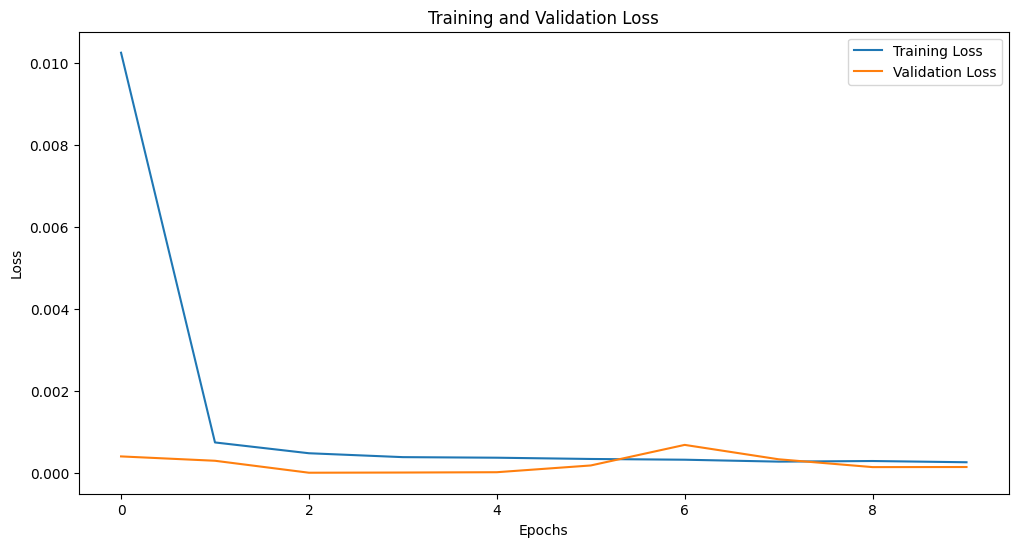

In [24]:
# loss_per_epoch = history.history['loss']
# plt.plot(range(len(loss_per_epoch)), loss_per_epoch)


# Example training and validation loss plot
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [25]:
# Make predictions
predictions_train = model.predict(X_train)

# Inverse transform the predicted and actual values to get them back to original scale
predictions_train = scaler.inverse_transform(predictions_train)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


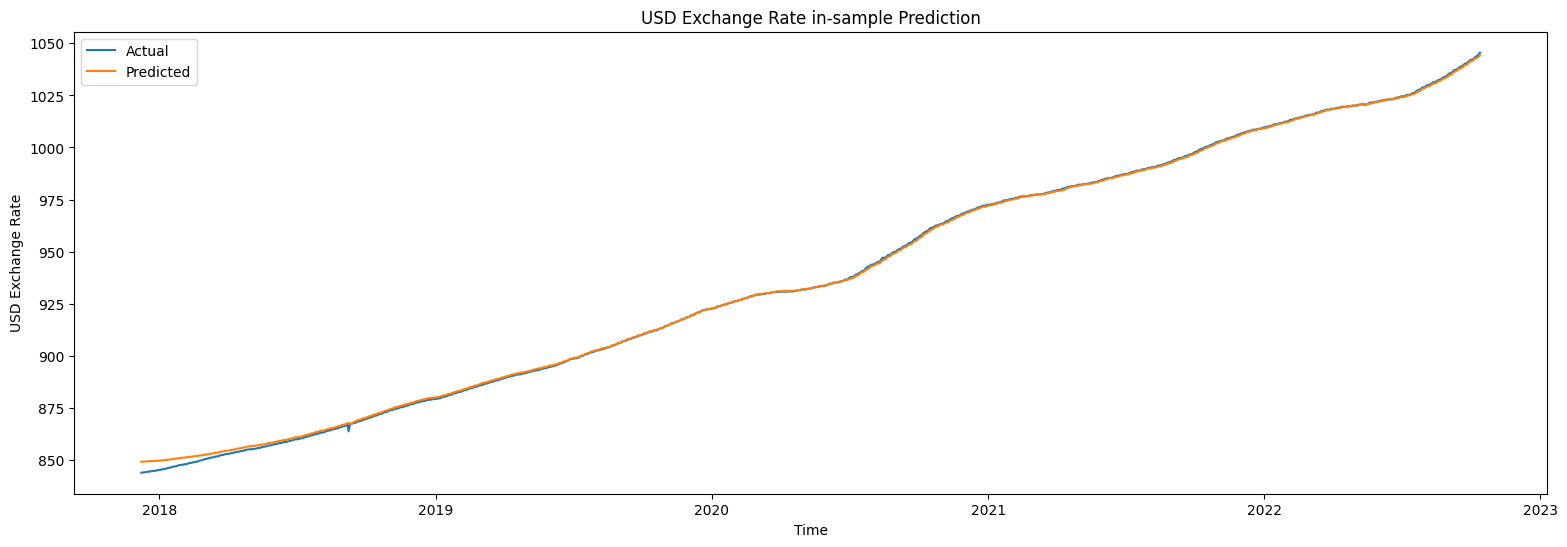

In [26]:
# Plot the results
plt.figure(figsize=(19, 6))
plt.plot(train_dates, y_train_actual, label='Actual')
plt.plot(train_dates, predictions_train, label='Predicted')
plt.title('USD Exchange Rate in-sample Prediction')
plt.xlabel('Time')
plt.ylabel('USD Exchange Rate')
plt.legend()
plt.show()

In [68]:
# Calculate MAE
mae_train = round(mean_absolute_error(y_train_actual, predictions_train),4)
print(f'Mean Absolute Error for test set (MAE): {mae_train}')

Mean Absolute Error for test set (MAE): 0.6477


In [53]:
from sklearn.metrics import mean_squared_error
from math import sqrt


rmse = sqrt(mean_squared_error(y_train_actual, predictions_train))
print(f"Training set prediction RMSE: {rmse:.4f}")

Training set prediction RMSE: 1.0241


In [28]:
# Make predictions
predictions_val = model.predict(X_val)

# Inverse transform the predicted and actual values to get them back to original scale
predictions_val = scaler.inverse_transform(predictions_val)
y_val_actual = scaler.inverse_transform(y_val.reshape(-1, 1))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


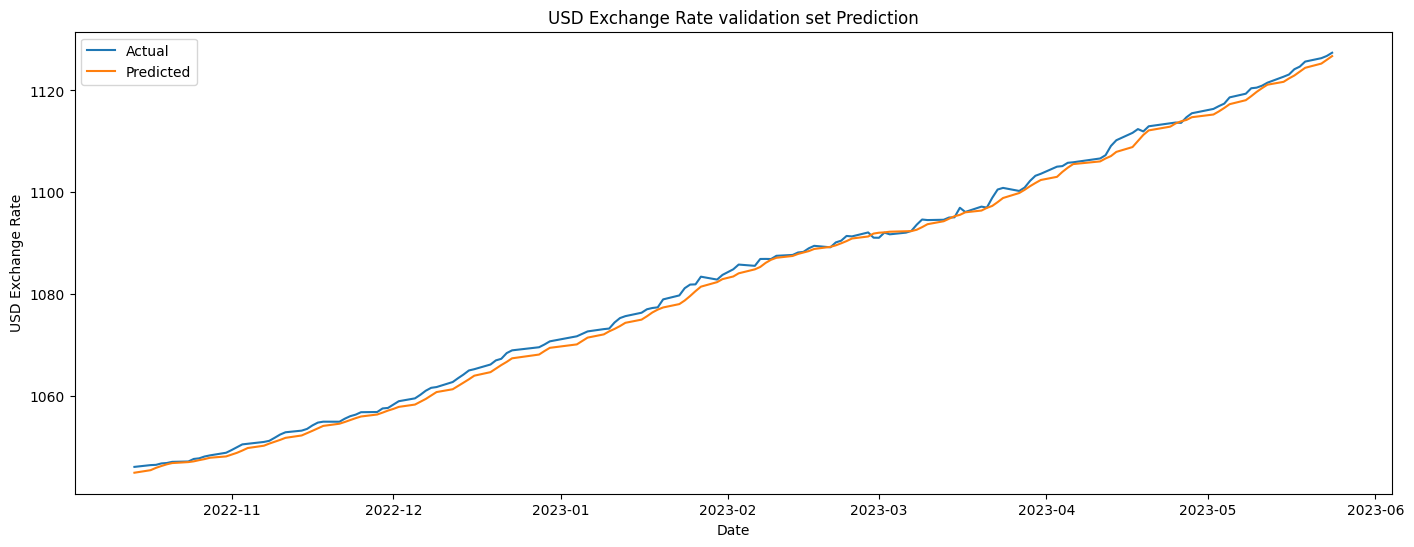

In [29]:
# Plot the results for visualization
plt.figure(figsize=(17, 6))
plt.plot(val_dates, y_val_actual, label='Actual')
plt.plot(val_dates, predictions_val, label='Predicted')
plt.title('USD Exchange Rate validation set Prediction')
plt.xlabel('Date')
plt.ylabel('USD Exchange Rate')
plt.legend()
plt.show()

In [66]:
# Calculate MAE
mae_val = round(mean_absolute_error(y_val_actual, predictions_val),4)
print(f'Mean Absolute Error for validation set (MAE): {mae_val}')

Mean Absolute Error for validation set (MAE): 0.9736


In [52]:
from sklearn.metrics import mean_squared_error
from math import sqrt


rmse = sqrt(mean_squared_error(y_val_actual, predictions_val))
print(f"Validation set prediction RMSE: {rmse:.4f}")

Validation set prediction RMSE: 1.1223


In [31]:
# Make predictions on the test set
test_predictions = model.predict(X_test)

# Inverse transform the predicted and actual values to get them back to original scale
test_predictions = scaler.inverse_transform(test_predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


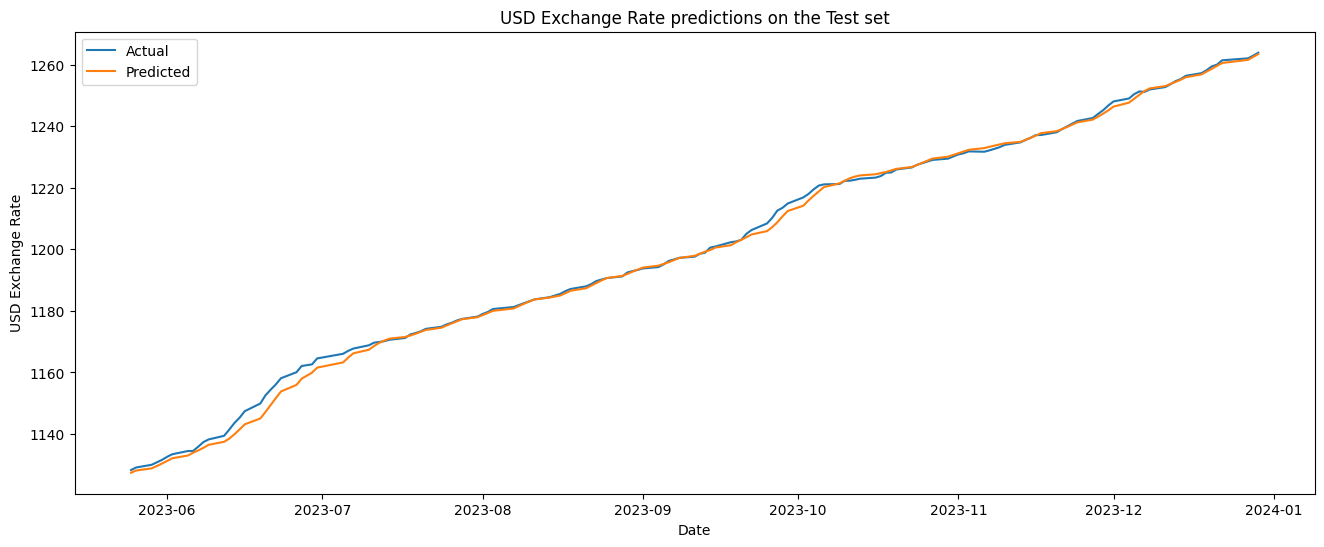

In [38]:
# Plot the results for visualization
plt.figure(figsize=(16, 6))
plt.plot(test_dates, y_test_actual, label='Actual')
plt.plot(test_dates, test_predictions, label='Predicted')
plt.title('USD Exchange Rate predictions on the Test set')
plt.xlabel('Date')
plt.ylabel('USD Exchange Rate')
plt.legend()
plt.show()

In [65]:
# Calculate MAE
mae_test = round(mean_absolute_error(y_test_actual, test_predictions),4)
print(f'Mean Absolute Error for test set (MAE): {mae_test}')

Mean Absolute Error for test set (MAE): 1.026


In [51]:
from sklearn.metrics import mean_squared_error
from math import sqrt


# Calculate RMSE
rmse = sqrt(mean_squared_error(y_test_actual, test_predictions))
print(f"Test set prediction RMSE: {rmse:.4f}")

Test set prediction RMSE: 1.5629


In [61]:
# Calculate the mean of the actual values
mean_actual = np.mean(USD_exchange_rate)

#calculate the baseline
y_train_mean = USD_exchange_rate.mean()
mae_baseline = round(mean_absolute_error(y_train_actual, ([y_train_mean] * len(y_train))),4)

print("Baseline model MAE:", (mae_baseline))

Baseline model MAE: 59.2355


In [45]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [50]:
# Calculate RMSE
rmse = sqrt(mean_squared_error(y_train_actual, ([y_train_mean] * len(y_train))))
print(f"Baseline model prediction RMSE: {rmse:.4f}")

Baseline model prediction RMSE: 71.5352


In [72]:
mae_values = {
    'Baseline MAE': mae_baseline,
    'Training set MAE': mae_train,
    'Validation set MAE': mae_val,
    'Test set MAE': mae_test
}

df_MAE = pd.DataFrame.from_dict(mae_values, orient='index', columns=['MAE value'])
df_MAE

,MAE value
Baseline MAE,59.2355
Training set MAE,0.6477
Validation set MAE,0.9736
Test set MAE,1.0260
